# GENOPYC TUTORIAL NOTEBOOK


In this tutorial we will implement genopyc library in investigating intervertebral disc degeneration (IDD) a complex trait that is one of the main causes of disc herniation and back pain. We will start by collecting SNPs associated to the trait throug genome wide association sudies (GWAS) and we will elucidate which pathways are perturbed from the variants.

# Install the libraries

In [ ]:
!pip install genopyc
!pip install graphlot

# Import all the necessary libraries

In [50]:
import genopyc as gp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast
import matplotlib_venn as pltv
import networkx as nx
import graphlot as gv
from upsetplot import from_contents
from upsetplot import UpSet

# Download variants associated to intervertebral disc degeneration (EFO_0000305) from the GWAS catalog 

In this notebook we will work with the variants associated with lumbar disc degeneration (EFO:0004994). The file can be downloaded [here](https://www.ebi.ac.uk/gwas/efotraits/EFO_0004994).

In [12]:
associations = pd.read_csv('./data/EFO_0004994_associations_export.tsv',sep='\t')
#Separate the riskAllele column in 2 and drop the column
associations[['rsid', 'RiskAllele']] = associations['riskAllele'].str.split('-', expand=True)
associations.drop('riskAllele',inplace=True,axis=1)
#set rsids as index
associations.set_index('rsid',inplace=True)
associations

,pValue,pValueAnnotation,riskFrequency,orValue,beta,ci,mappedGenes,traitName,efoTraits,bgTraits,accessionId,locations,pubmedId,author,RiskAllele
rsid,,,,,,,,,,,,,,,
rs17034687,2.000000e-09,-,0.09,-,0.23 unit increase,[0.16-0.30],"CRBN,SUMF1",Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,3:3638168,22993228,Williams FM,C
rs2187689,3.000000e-08,-,0.08,-,0.23 unit increase,[0.15-0.31],"HLA-Z,PPP1R2P1",Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,6:32884870,22993228,Williams FM,C
rs926849,3.000000e-08,-,0.31,-,0.13 unit decrease,[0.083-0.177],PRKN,Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,6:161740587,22993228,Williams FM,C
rs7744666,6.000000e-08,-,0.10,-,0.2 unit increase,[0.13-0.27],"PPP1R2P1,HLA-Z",Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,6:32891935,22993228,Williams FM,C
rs11969002,6.000000e-08,-,0.10,-,0.2 unit increase,[0.13-0.27],"HLA-Z,PPP1R2P1",Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,6:32891971,22993228,Williams FM,A
rs4802666,5.000000e-06,-,0.27,-,0.13 unit decrease,[0.073-0.187],MYH14,Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,19:50217817,22993228,Williams FM,A
rs7896691,2.000000e-06,-,0.10,-,0.17 unit increase,[0.10-0.24],PFKP,Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,10:3112981,22993228,Williams FM,C
rs10998466,4.000000e-06,-,0.01,-,0.53 unit decrease,[0.31-0.75],STOX1,Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,10:68866673,22993228,Williams FM,A
rs1981483,4.000000e-06,-,0.42,-,0.11 unit increase,[0.065-0.155],PIGQ,Disc degeneration (lumbar),lumbar disc degeneration,-,GCST001687,16:580665,22993228,Williams FM,A


Alternatively the associations can be retrieved with get_associations() function directly from GWAS catalog. The function accepts the efo code of the trait as an argument.

In [13]:
%%time 
gp.get_associations('EFO_0004994',verbose=True)

Querying associations for EFO_0004994...



Building the dataframe...
CPU times: user 65.9 ms, sys: 10.7 ms, total: 76.7 ms
Wall time: 2.97 s


,variantid,p-value,risk_allele,RAF,beta,CI,mapped_gene,SE,study_url
0,rs17034687,2.0e-09,C,0.09,0.23,[0.16-0.30],intergenic,0.038,https://www.ebi.ac.uk/gwas/rest/api/associatio...
1,rs2187689,3.0e-08,C,0.08,0.23,[0.15-0.31],PSMB9,0.041,https://www.ebi.ac.uk/gwas/rest/api/associatio...
2,rs926849,3.0e-08,C,0.31,0.13,[0.083-0.177],PARK2,0.024,https://www.ebi.ac.uk/gwas/rest/api/associatio...
3,rs7744666,6.0e-08,C,0.10,0.20,[0.13-0.27],intergenic,0.037,https://www.ebi.ac.uk/gwas/rest/api/associatio...
4,rs11969002,6.0e-08,A,0.10,0.20,[0.13-0.27],intergenic,0.037,https://www.ebi.ac.uk/gwas/rest/api/associatio...
5,rs6457690,9.0e-08,A,0.10,0.19,[0.12-0.26],intergenic,0.036,https://www.ebi.ac.uk/gwas/rest/api/associatio...
6,rs1029296,9.0e-08,C,0.10,0.19,[0.12-0.26],intergenic,0.036,https://www.ebi.ac.uk/gwas/rest/api/associatio...
7,rs6936004,1.0e-07,C,0.10,0.19,[0.12-0.26],intergenic,0.036,https://www.ebi.ac.uk/gwas/rest/api/associatio...
8,rs3749982,1.0e-07,A,0.10,0.19,[0.12-0.26],intergenic,0.037,https://www.ebi.ac.uk/gwas/rest/api/associatio...
9,rs9469300,1.0e-07,A,0.10,0.19,[0.12-0.26],intergenic,0.037,https://www.ebi.ac.uk/gwas/rest/api/associatio...


## Get the genomic coordinates of the variants 

We will store the list of SNPs and location of the variants in 2 variables to work with them. The position can be either get from the association dataframe or with the function get_variants_position() that accept a list of rsids as argument. IN this case we will use the coordinates already in the association dataframe.

In [14]:
variants=list(set(associations.index.tolist()))
variants[:10]

['rs2484992',
 'rs4802666',
 'rs10046257',
 'rs4148933',
 'rs2484990',
 'rs10214886',
 'rs1250307',
 'rs7896691',
 'rs1245582',
 'rs9469300']

In [15]:
variant_positions=[(i,r['locations'].split(':')[0],r['locations'].split(':')[1]) for i,r in associations.iterrows()]
variant_positions[:10]

[('rs17034687', '3', '3638168'),
 ('rs2187689', '6', '32884870'),
 ('rs926849', '6', '161740587'),
 ('rs7744666', '6', '32891935'),
 ('rs11969002', '6', '32891971'),
 ('rs4802666', '19', '50217817'),
 ('rs7896691', '10', '3112981'),
 ('rs10998466', '10', '68866673'),
 ('rs1981483', '16', '580665'),
 ('rs1154053', '8', '4427868')]

In [16]:
gp.get_variants_position(variants)[:10]

[('rs10046257', '6', 32886920),
 ('rs9301951', '13', 94300578),
 ('rs1205863', '6', 11943293),
 ('rs7163797', '15', 67072574),
 ('rs7907616', '10', 72000418),
 ('rs2484992', '10', 31223169),
 ('rs926849', '6', 161740587),
 ('rs3749982', '6', 32894830),
 ('rs11754641', '6', 64926030),
 ('rs10214886', '6', 32889642)]

# Get regulatory elements for a list of variants 


A first approach could be to investigate the elements that lie in a specific region surrounding variant of interest. This can be easily done with the get_ov_elements() function. It accepts genomic coordinates chromosome, start and end of a specific genomic region and it returns the elements that overlap it. The feature keyword is a list containing the specific features we want to retrieve. Refer to the [Documentation](https://rest.ensembl.org/documentation/info/overlap_region) from ensembl in order to have a full list of possible features that can be retrieved.

The function get_ov_region has a mode SNP  in which the function accepts as an input a single genetic variant, and a mode region, in which  a genomic area (chromosome, start, stop) can be passed.

The example below shows how to inspect a region of 500 bp around the rsid rs2901157 which will return genes and motif features in that genomic area



In [17]:
overlapping_elements = gp.get_ov_region('rs1981483',features=['regulatory','gene','motif'],mode='SNP',window=200)


In [18]:
overlapping_elements[2]

,binding_matrix_stable_id,end,feature_type,score,seq_region_name,stable_id,start,strand,transcription_factor_complex
0,ENSPFM0550,580571,motif,0.167248,16,ENSM00536901928,580547,-1,TEAD4::FOXI1
1,ENSPFM0455,580579,motif,-0.61226,16,ENSM00607925648,580550,1,POU2F1::EOMES
2,ENSPFM0547,580578,motif,-0.353989,16,ENSM00621307960,580551,-1,TEAD4::FOXI1
3,ENSPFM0548,580578,motif,2.04745,16,ENSM00555128830,580552,1,TEAD4::FOXI1
4,ENSPFM0467,580568,motif,0.571308,16,ENSM00625515756,580554,1,PRDM1
...,...,...,...,...,...,...,...,...,...
65,ENSPFM0233,580600,motif,6.370897,16,ENSM00621738886,580587,-1,GCM1::FOXI1
66,ENSPFM0436,580599,motif,3.616267,16,ENSM00417533345,580590,-1,"PBX4::HOXA10,PBX4::HOXA1"
67,ENSPFM0431,580599,motif,-1.702089,16,ENSM00415069205,580590,-1,"PAX7,PAX3"
68,ENSPFM0293,580600,motif,0.892623,16,ENSM00580901800,580591,-1,"HOXC10,HOXA13,HOXB13,HOXC13,HOXD13"


The result is a list of dataframes for every feature type we looked for. 

For example we can retrieve all the transcription factor binding sites in the area. You can learn more about [motifs](https://www.ensembl.info/2018/10/15/new-ensembl-motif-features/) and [regulatory features](https://www.ensembl.org/info/genome/funcgen/index.html) in the official Ensembl documentation.



One Interesting approach could be to investigate expression quantitative trait loci (eqtls) for a given variant. 
These studies correlate genetic variations with the altered expression of a gene, more likely the SNP has an effect on the expression of a specific candidate gene.

# Connect variants to genes through Eqtls

Genopyc allows you to retrieve all the eqtls of a given variant the code. Data are fetched from [EBI](https://www.ebi.ac.uk/eqtl/). [Documentation](https://www.ebi.ac.uk/eqtl/api-docs/#accessing-the-api) available. Here we will get the eqtls for the variants. 
The function can take a while to run

In [19]:
eqtls_dict={rsid:gp.get_eqtl_df(rsid) for rsid in variants}

In [20]:
eqtls_dict['rs4802666']

,variantid,p_value,log_pval,beta,alt,gene_id,tissue,study_id,tissue_name
0,rs4802666,0.003025,2.519249,-0.128984,A,ENSG00000224420,UBERON_0009834,BrainSeq,dorsolateral prefrontal cortex
1,rs4802666,0.002331,2.632488,-0.138887,A,ENSG00000269392,UBERON_0009834,BrainSeq,dorsolateral prefrontal cortex
2,rs4802666,0.004577,2.339461,0.082464,A,ENSG00000105357,UBERON_0001013,FUSION,adipose tissue
3,rs4802666,0.000979,3.009354,0.056015,A,ENSG00000142528,UBERON_0001134,FUSION,skeletal muscle tissue
4,rs4802666,0.003577,2.446533,-0.094559,A,ENSG00000039650,UBERON_0002190,GTEx_V8,subcutaneous adipose tissue


## To visualize better the data and  we can build an heterogeneous network 



## List available tissue in the dataframes of eqtls


In [21]:
list_of_eqtls_dataframes = list(eqtls_dict.values())
eqtl_tissues = set(list(sum([d.tissue_name.tolist() for d in list_of_eqtls_dataframes],[])))
eqtl_tissues


{"Ammon's horn",
 'CD14-low, CD16-positive monocyte',
 'CD14-positive, CD16-negative classical monocyte',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 None,
 "Peyer's patch",
 'T-helper 17 cell',
 'adipose tissue',
 'adrenal gland',
 'amygdala',
 'anterior cingulate cortex',
 'anterior lingual gland',
 'ascending aorta',
 'blood',
 'body of pancreas',
 'breast epithelium',
 'caudate nucleus',
 'cerebellum',
 'coronary artery',
 'dorsolateral prefrontal cortex',
 'esophagus muscularis mucosa',
 'esophagus squamous epithelium',
 'fibroblast',
 'frontal cortex',
 'gastrocnemius medialis',
 'gastroesophageal sphincter',
 'hypothalamus',
 'left ventricle myocardium',
 'lower leg skin',
 'macrophage',
 'memory regulatory T cell',
 'neutrophil',
 'nucleus accumbens',
 'omental fat pad',
 'pituitary gland',
 'prostate gland',
 'putamen',
 'right atrium auricular region',
 'right lobe of liver',
 'sensory neuron',
 'sigmoid colon',
 'skeletal muscle tissue',
 'skin o

## By using the function make_eqtl_network() we will build a network of variants - gene - tissue

The network will help us understand better the action of the variant in fact a red edge will show us if a variant is inhibiting the transcription of a specific gene while a green edge will be displayed if the variant is enhanching the transcription. We will filter the results for skeletal muscle tissue in order to focus the attention in this specific tissue.


In [22]:
eqtl_network_smt = gp.make_eqtl_network(list_of_eqtls_dataframes,tissue_name=True,gene_symbol=True,tissue='skeletal muscle tissue')


The result will be a network where nodes are either variants genes or tissues and edges between variants and genes exist if the variant is inhibiting or enhancing the expression of the gene. Edges between genes and tissues exist if the gene is expressed in that given tissue.

## By using the graphlot library we will visualize the result filtering for skeletal muscle tissue. 

The graphlot library is a flexible network visualization tool. It allows us to visualize networks in 2d and 3d mode and col or the nodes and the edges based on the data encoded in our eqtl_network. Here the green edges show an enhanching in the transcription while red an inhibition. The width is proportional to the beta (effect) that the variant has on the transcription of the gene.

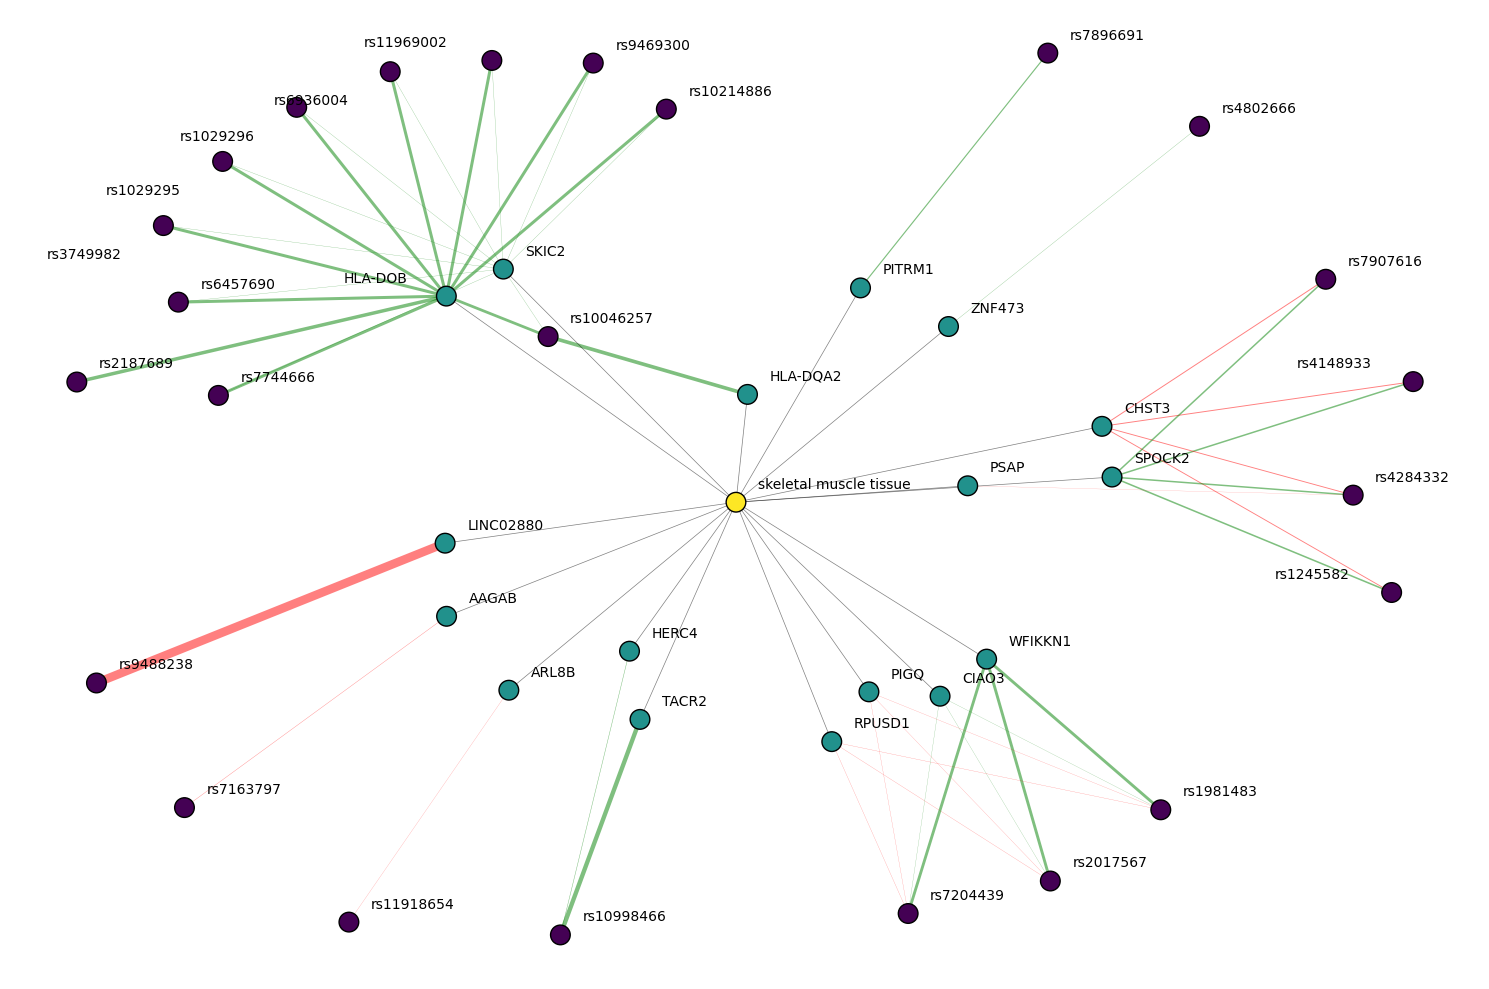

In [23]:
gv.visualize_network(
                        eqtl_network_smt,mode='2d',
                        layout='auto',
                        edge_annotation_attributes=['beta'],
                        edge_color_attribute='color',
                        node_color_attribute='tipo',
                        node_annotation=True,
                        show_node_label_3d = True,
                        edge_attribute_width='beta',
                        factor_edge_width=4,
                        node_size=200,
                    )

Eqtl is an interesting way to connect variants to genes, here we will take the genes affected from variantions through eqtls i.e. an alteration in the transcription mechanisms and store them in a variable called eqtl_genes


In [24]:
eqtl_genes = [node[0] for node in eqtl_network_smt.nodes(data=True) if node[1]['tipo'] == 'gene']
eqtl_genes

['ZNF473',
 'SKIC2',
 'HLA-DOB',
 'HLA-DQA2',
 'CHST3',
 'SPOCK2',
 'PITRM1',
 'PSAP',
 'LINC02880',
 'RPUSD1',
 'CIAO3',
 'PIGQ',
 'WFIKKN1',
 'ARL8B',
 'AAGAB',
 'TACR2',
 'HERC4']

# Run VEP to investigate variant consequences, plot the results and connect variant to genes.

With the function.VEP we can programmatically run VEP to investigate SNP consequences. The function accepts either a list of rsids or HGVS ids. For our purpose we will use HGVS notation since GWAS studies gives us precise information relative to reference and alternative allele.

## Convert rsids to HGVS notation

An example of HGVS notation is 9:g.22125504G>C where:

- 9 is the chromosome
- g means genome position
- 22125504 is the chromosome position
- G and C  are the reference and alternative allele

Given that the information regarding ancestral allele is still missing; a drawback of using rsids as variants identifiers is that for a single rsid we can have more than one nucleotide substitution. The the strategy here is to keep the ancestral allele that is more frequent. This can be easily done with the function gp.get_ancestral_allele() that accepts a list of rsids as argument.



The information related to ancestral allele is retrieved querying accessing Ensembl genome browser.

In [25]:
# Getting the risk allele from the association dataframe
variant_risk_alleles=dict(zip(associations.index.tolist(),[ra for ra in associations.RiskAllele.tolist()]))

# Getting the genomic location from the association dataframe
variant_genomic_locations=dict(zip([tup[0] for tup in variant_positions],[tup[2] for tup in variant_positions]))
variant_chromosomes=dict(zip([tup[0] for tup in variant_positions],[tup[1] for tup in variant_positions]))

# Retrieving the ancestral allele with the function get_ancestral_allele
variant_ancestral_allele = gp.get_ancestral_allele(variants)

To merge all the information retrieved and convert to HGVS notation, run:

In [26]:
hgvs_dict = {}

for variant in associations.index.tolist():
    try:
        hgvs_notation=str(variant_chromosomes[variant])+':g.'+str(variant_genomic_locations[variant])+str(variant_ancestral_allele[variant])+'>'+str(variant_risk_alleles[variant])
        hgvs_dict[variant] = hgvs_notation
    except Exception as error:
        print(f'Error for rsid {variant}: ' + repr(error))
hgvs_dict

{'rs17034687': '3:g.3638168C>C',
 'rs2187689': '6:g.32884870T>C',
 'rs926849': '6:g.161740587T>C',
 'rs7744666': '6:g.32891935T>C',
 'rs11969002': '6:g.32891971G>A',
 'rs4802666': '19:g.50217817G>A',
 'rs7896691': '10:g.3112981T>C',
 'rs10998466': '10:g.68866673A>A',
 'rs1981483': '16:g.580665A>A',
 'rs1154053': '8:g.4427868C>C',
 'rs2484990': '10:g.31226203T>C',
 'rs1250307': '10:g.31207045G>A',
 'rs7204439': '16:g.611335C>C',
 'rs2484992': '10:g.31223169T>C',
 'rs9488238': '6:g.113695931A>A',
 'rs1205863': '6:g.11943293G>G',
 'rs11918654': '3:g.5146561C>C',
 'rs2657195': '8:g.91547687A>A',
 'rs11754641': '6:g.64926030C>C',
 'rs12805875': '11:g.103658904A>A',
 'rs980238': '8:g.4425096A>A',
 'rs7103004': '11:g.103655296C>C',
 'rs4554859': '11:g.103659638G>G',
 'rs7118412': '11:g.103655026A>A',
 'rs2017567': '16:g.587212C>C',
 'rs6457690': '6:g.32887940G>A',
 'rs1029296': '6:g.32888604T>C',
 'rs6936004': '6:g.32889157T>C',
 'rs3749982': '6:g.32894830T>A',
 'rs9469300': '6:g.32892975G>A'

The result of this snippet of code is a dictionary with the rsid as key and the correspondent variant in HGVS notation in a way that we can easily retrieve the mapping between them. 

We can see that sometimes the risk allele is the same of the ancestral allele. It can happen that the alternative allele is more frequent that the alternative allele or that the ancestral allele is the risk allele when for example the alternate allele has some protection (negative odd ratio) in respect to the phenotype.

Also we can see that sometimes the risk allele is marked as "?" from GWAS. In this case we don't have information related to the variant related to the disease.

With the HGVS approach these SNPs will be excluded from the analysis. A possible approach would be to use the input type = "rsid" in the function gp.VEP()

[VEP](https://www.ensembl.org/Tools/VEP) can be run using hgvs notation by passing the argument input_type='hgvs' and as an argument of the function the list 

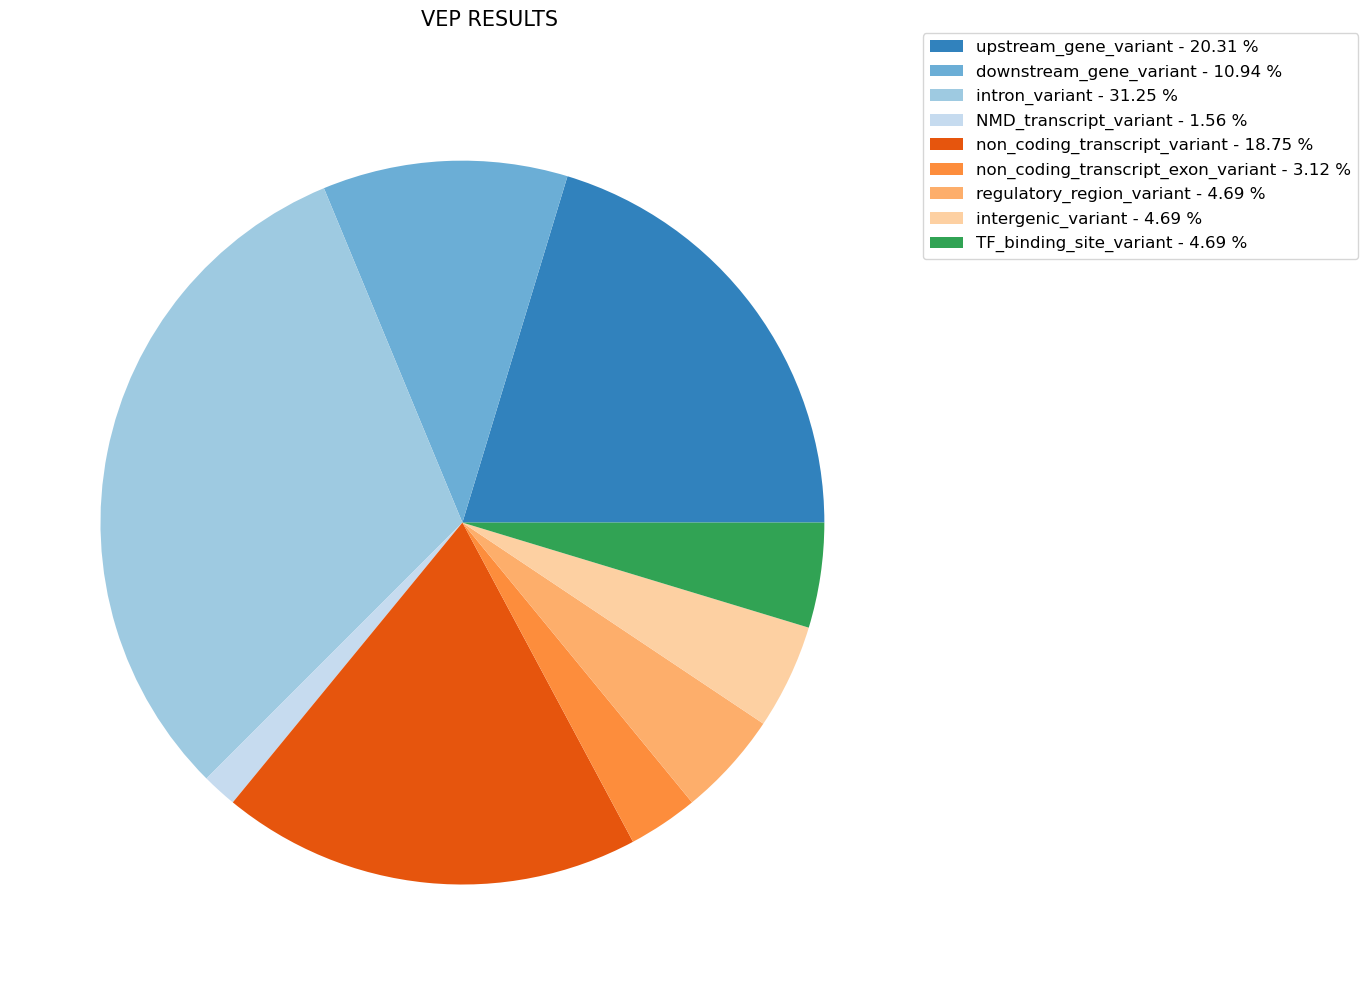

In [27]:
vep_consequences_hgvs=gp.VEP(list(hgvs_dict.values()),plot=True,input_type='hgvs')

The output is a list containing 4 dataframes. VEP separates the data in transcript effects, regulatory effects, non coding effects and regulatory motif effects. 
Below, we show  the second dataframe in the list, that stores all the regulatory effects. 

In [28]:
vep_consequences_hgvs[2]

,variantid,effects,biotype,impact
0,6:g.32886920G>A,['regulatory_region_variant'],CTCF_binding_site,MODIFIER
1,6:g.32886920G>A,['regulatory_region_variant'],enhancer,MODIFIER
2,6:g.32894830T>A,['regulatory_region_variant'],promoter,MODIFIER


## Relate variants to genes with VEP consequences
Vep is another way in which we can bind variants and genes, here we will create 2 variables: genes associated through transcription factors (regulatory) and coding variants.

The connection variants - transcription factors - genes is carried out querying [TF_link database](https://tflink.net/).

In [29]:
vep_consequences_hgvs[3]

,variantid,effects,TF,impact_score
0,6:g.32894830T>A,['TF_binding_site_variant'],['E2F1::NHLH1'],-0.012
1,6:g.32894830T>A,['TF_binding_site_variant'],['E2F1::ELK1'],0.043
2,6:g.32886920G>A,['TF_binding_site_variant'],['HOXB2::RFX5'],0.006


### TF AFFECTED

In [30]:
tflink = pd.read_csv('./data/TFLink_Homo_sapiens_interactions_SS_simpleFormat_v1.0.tsv',sep='\t')

In [31]:
tf_affected = vep_consequences_hgvs[3].TF.tolist()
tf_affected = [ast.literal_eval(e) for e in tf_affected]
tf_affected = sum(tf_affected,[])
tf_affected = set(sum([l.split("::") for l in tf_affected],[]))

#Retrieve the genes regulated by these TFs

genes = []

for tf in tf_affected:
    tf_genes = tflink[tflink["Name.TF"] == tf]["NCBI.GeneID.Target"].tolist()
    genes.extend(tf_genes)
## Prettify the list (remove duplicates, and strings with multiple genes)

genes_tfbs = list(set(sum([g.split(";") for g in [d for d in genes if d != '-']],[])))

print(f"A total of {len(genes_tfbs)} genes are controlled from the transcription factors")

A total of 870 genes are controlled from the transcription factors


There are a lot of genes whose transcription is controlled from the TFS affected by the variants because TFLink is not tissue specific. A possible approach would restrict the set to the genes actually expressed in the disc. We will use data from a proteomics study called [Dipper](https://elifesciences.org/articles/64940v2). Data is freely available [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147383).

Moreover we will need to convert between genes identifiers (entrez, ensembl, gene symbol...) and for this purpose we will use [biomapy](https://pypi.org/project/biomapy/) library

In [32]:
protein_expressed_disc = pd.read_csv('./data/dipper_protein_expression.csv',index_col = 0 )
genes_list = protein_expressed_disc['Gene.names'].tolist()
entrez_list =gp.gene_mapping_many(genes_list,'symbol','entrez')
entrez_list = [str(g) for g in list(filter(None,entrez_list))]


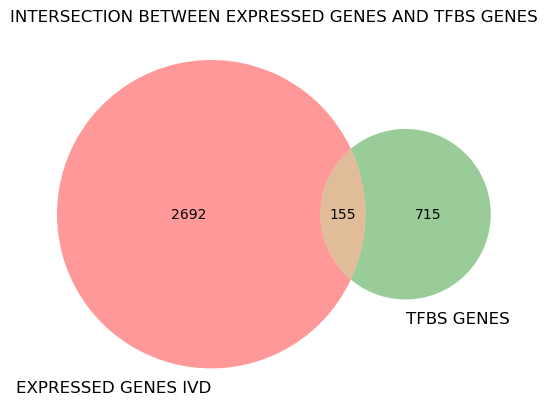

In [33]:
pltv.venn2([set(entrez_list),set(genes_tfbs)],set_labels=["EXPRESSED GENES IVD","TFBS GENES"])
plt.title("INTERSECTION BETWEEN EXPRESSED GENES AND TFBS GENES")
plt.show()

In [34]:
expressed_genes_tfbs = list((set(entrez_list).intersection(set(genes_tfbs))))
expressed_genes_tfbs[:10]

['5591',
 '6876',
 '351',
 '2180',
 '2878',
 '23589',
 '6647',
 '83641',
 '1854',
 '56944']

In [36]:
#Convert them to symbol
expressed_genes_tfbs_symbol = gp.gene_mapping_many([int(a) for a in expressed_genes_tfbs],'entrez','symbol')
expressed_genes_tfbs_symbol[:10]

['PRKDC',
 'TAGLN',
 'APP',
 'ACSL1',
 'GPX3',
 'CARHSP1',
 'SOD1',
 'FAM107B',
 'DUT',
 'OLFML3']

### CODING VARIANTS

In [37]:
genes_vep = set(vep_consequences_hgvs[1].ENSID.tolist())
print(f"A total of {len(genes_vep)} has been associated through VEP coding consequences")

A total of 7 has been associated through VEP coding consequences


In [38]:
genes_vep_symbol = gp.gene_mapping_many(genes_vep,'ensembl','symbol')
genes_vep_symbol = list(filter(None,genes_vep_symbol))
genes_vep_symbol

['MYH14', 'ZEB1-AS1', 'LOC100294145', 'HLA-Z', 'GPC6']

# CONNECT VARIANTS TO GENES FROM GWAS CATALOG

When a GWAS is performed usually the author report an associated gene for every variant they discover. In case the variant is intergenic they will mention the closest upstream and downstream genes. This information is reported in the column mappedGenes of our initial dataframe.

In [39]:
genes_gwas = list(set(sum([g.split(',') for g in associations.mappedGenes.tolist()],[])))
genes_gwas

['HIVEP1',
 'AMD1P4',
 'PFKP',
 'MARCKS',
 'SLC26A7',
 'CHST3',
 'MIR4693',
 'PPP1R2P1',
 'ARL8B',
 'LINC02541',
 'HLA-Z',
 'GPC6',
 'DYNC2H1',
 'PRKN',
 'SUMF1',
 'STOX1',
 'CSMD1',
 'RAB40C',
 'RN7SKP231',
 'SMAD3',
 'SPOCK2',
 'EYS',
 'LINC02664',
 'PIGQ',
 'CRBN',
 'MYH14',
 'ZEB1-AS1']

# Retrieve genes associated to GWAS loci exploiting [Open Target L2G pipeline](https://genetics-docs.opentargets.org/our-approach/prioritising-causal-genes-at-gwas-loci-l2g)

The first thing we need to do is to convert variant in the format chr_position_reference_alternative allele, this can be done with the function convert_variants of genopyc.
Then we can run the OTG pipeline with the functions OT_L2G. The result is a dataframe with 3 columns with the variant id, the gene and the score assigned by the pipeline. Alternatively by not specifying output = 'all' the top scoring genes in a list will be obtained.

In [40]:
variants_to_study_ot = gp.convert_variants(variants,source='rsid',target = 'variantid')
variants_to_study_ot=list(filter(None,variants_to_study_ot))
variants_to_study_ot

['10_31223169_T_C',
 '19_50217817_G_A',
 '6_32886920_G_A',
 '10_72000132_T_C',
 '10_31226203_T_C',
 '6_32889642_T_A',
 '10_31207045_G_A',
 '10_3112981_C_T',
 '10_72018509_C_T',
 '6_32892975_G_A',
 '6_32891971_G_A',
 '10_71974194_T_C',
 '11_103658904_A_G',
 '11_103659638_G_T',
 '11_103655026_A_G',
 '8_4425096_C_A',
 '6_161740587_C_T',
 '6_113695931_A_G',
 '16_587212_T_C',
 '3_5146561_T_C',
 '13_94300578_T_C',
 '10_72000418_A_G',
 '6_32889157_T_C',
 '6_32888604_T_C',
 '6_32884870_T_C',
 '6_11943293_T_G',
 '16_580665_G_A',
 '8_4427868_G_C',
 '6_32888705_T_C',
 '8_91547687_A_G',
 '8_4427170_G_A',
 '11_103655296_C_T',
 '6_64926030_C_G',
 '16_611335_T_C',
 '15_67072574_C_A',
 '6_32894830_T_A',
 '10_68866673_A_G',
 '3_3638168_C_G',
 '6_32891935_T_C',
 '6_32887940_G_A']

The function accepts a list of variants and the output is the list of highest scoring genes from L2G pipeline. There is also a flag mode that if is equal to 'all' gives back the dataframe with every gene with associated score from the pipeline

In [41]:
OT_genes = gp.OT_L2G(variants_to_study_ot)
len(OT_genes)

30

In [43]:
OT_genes_symbol = gp.gene_mapping_many(OT_genes,'ensembl','symbol')
OT_genes_symbol

['PIGQ',
 'TAP1',
 'FBXL16',
 'NHLRC4',
 'PFKP',
 'CIAO3',
 'JMJD8',
 'HAGHL',
 'PRR35',
 'SPOCK2',
 'PITRM1',
 'EDEM1',
 'SMAD3',
 'WFIKKN1',
 'RHBDL1',
 'MYH14',
 'RAB40C',
 'ARL8B',
 'ASCC1',
 'WDR90',
 'NME4',
 'RHOT2',
 'HLA-DRB5',
 'WDR24',
 'METTL26',
 'ANTKMT',
 'CHST3',
 'METRN',
 'PSMB9',
 'HIVEP1']

# Overlapping of the retrieved genes

So far we connected variants to genes in several ways, we could analyze any overlap between these methods. We will plot the resuls. For this task we will use an interface with R in order to exploit [UpSet plot library](https://krassowski.github.io/complex-upset/index.html) using [rpy2 interface](https://rpy2.github.io/).

## Prepare the data to visualize



In [52]:
all_genes = list(set(OT_genes_symbol+genes_gwas+expressed_genes_tfbs_symbol+genes_vep_symbol))
gene_categories = ['OT','GWAS','TFBS_VEP','CODING_VEP','EQTLS']
gene_sets = [ OT_genes_symbol,genes_gwas,expressed_genes_tfbs_symbol,genes_vep_symbol,eqtl_genes]
data = from_contents(dict(zip(gene_categories,gene_sets)))



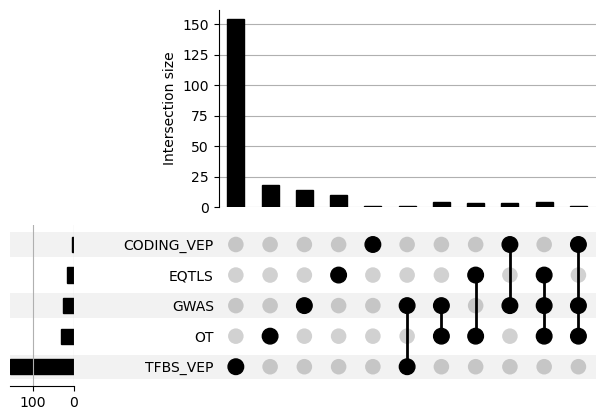

In [53]:
UpSet(data)


We can see that we still have a big number of genes controlled by transcription factors affected by variants but there is little to no overlap with other categories meaning that this is a very unspecific way of connecting variants to genes.

On the other hand there is a cluster of overapping between genes prioritize form GWAS, OT and EQTLS meaning that these methods are detecting the same clusters of genes and thus pathways that could be relevant to the disease. 

In oreder to study the functions and pathways enriched in the genes we will perform a fucnction enrichment analysis on the set of genes prioritized from GWAS and OT genetics.



In [54]:
print("OTL2G GENES: \n",OT_genes_symbol,"\n\n")

print( "GWAS GENES: \n", genes_gwas)

OTL2G GENES: 
 ['PIGQ', 'TAP1', 'FBXL16', 'NHLRC4', 'PFKP', 'CIAO3', 'JMJD8', 'HAGHL', 'PRR35', 'SPOCK2', 'PITRM1', 'EDEM1', 'SMAD3', 'WFIKKN1', 'RHBDL1', 'MYH14', 'RAB40C', 'ARL8B', 'ASCC1', 'WDR90', 'NME4', 'RHOT2', 'HLA-DRB5', 'WDR24', 'METTL26', 'ANTKMT', 'CHST3', 'METRN', 'PSMB9', 'HIVEP1'] 


GWAS GENES: 
 ['HIVEP1', 'AMD1P4', 'PFKP', 'MARCKS', 'SLC26A7', 'CHST3', 'MIR4693', 'PPP1R2P1', 'ARL8B', 'LINC02541', 'HLA-Z', 'GPC6', 'DYNC2H1', 'PRKN', 'SUMF1', 'STOX1', 'CSMD1', 'RAB40C', 'RN7SKP231', 'SMAD3', 'SPOCK2', 'EYS', 'LINC02664', 'PIGQ', 'CRBN', 'MYH14', 'ZEB1-AS1']


# Function enrichment analysis

## Function enrichment analysis on GWAS genes

In [57]:
def PlotEnrich(gene_list,pval):
    gp.plot_enrichment_analysis_network(gene_list,pval,fontsize=30,layout = 'spring',colormap='Blues',edgecolor='grey',
                                    mkcolor='grey',figsize=(20,15),k=100,factor=1.1,cbarfontsize=20,mkfsize=2500,
                                    ha='center',va='center',legend=True,legend_fontsize=20,legend_col=1, legend_columnspacing=3,legend_labelspacing=3,
                                    legend_location=(1.5,0.8),legend_title='Number of Genes',cbar_loc=(0,0))

In [58]:
PlotEnrich(genes_gwas,0.05)

Couldn't retrieve significantly enriched functions for the query list of genes:

 ['HIVEP1', 'AMD1P4', 'PFKP', 'MARCKS', 'SLC26A7', 'CHST3', 'MIR4693', 'PPP1R2P1', 'ARL8B', 'LINC02541', 'HLA-Z', 'GPC6', 'DYNC2H1', 'PRKN', 'SUMF1', 'STOX1', 'CSMD1', 'RAB40C', 'RN7SKP231', 'SMAD3', 'SPOCK2', 'EYS', 'LINC02664', 'PIGQ', 'CRBN', 'MYH14', 'ZEB1-AS1']


# Implementation of Open Target L2G pipeline is prioritizing genes involved in pathways relevant to the disease

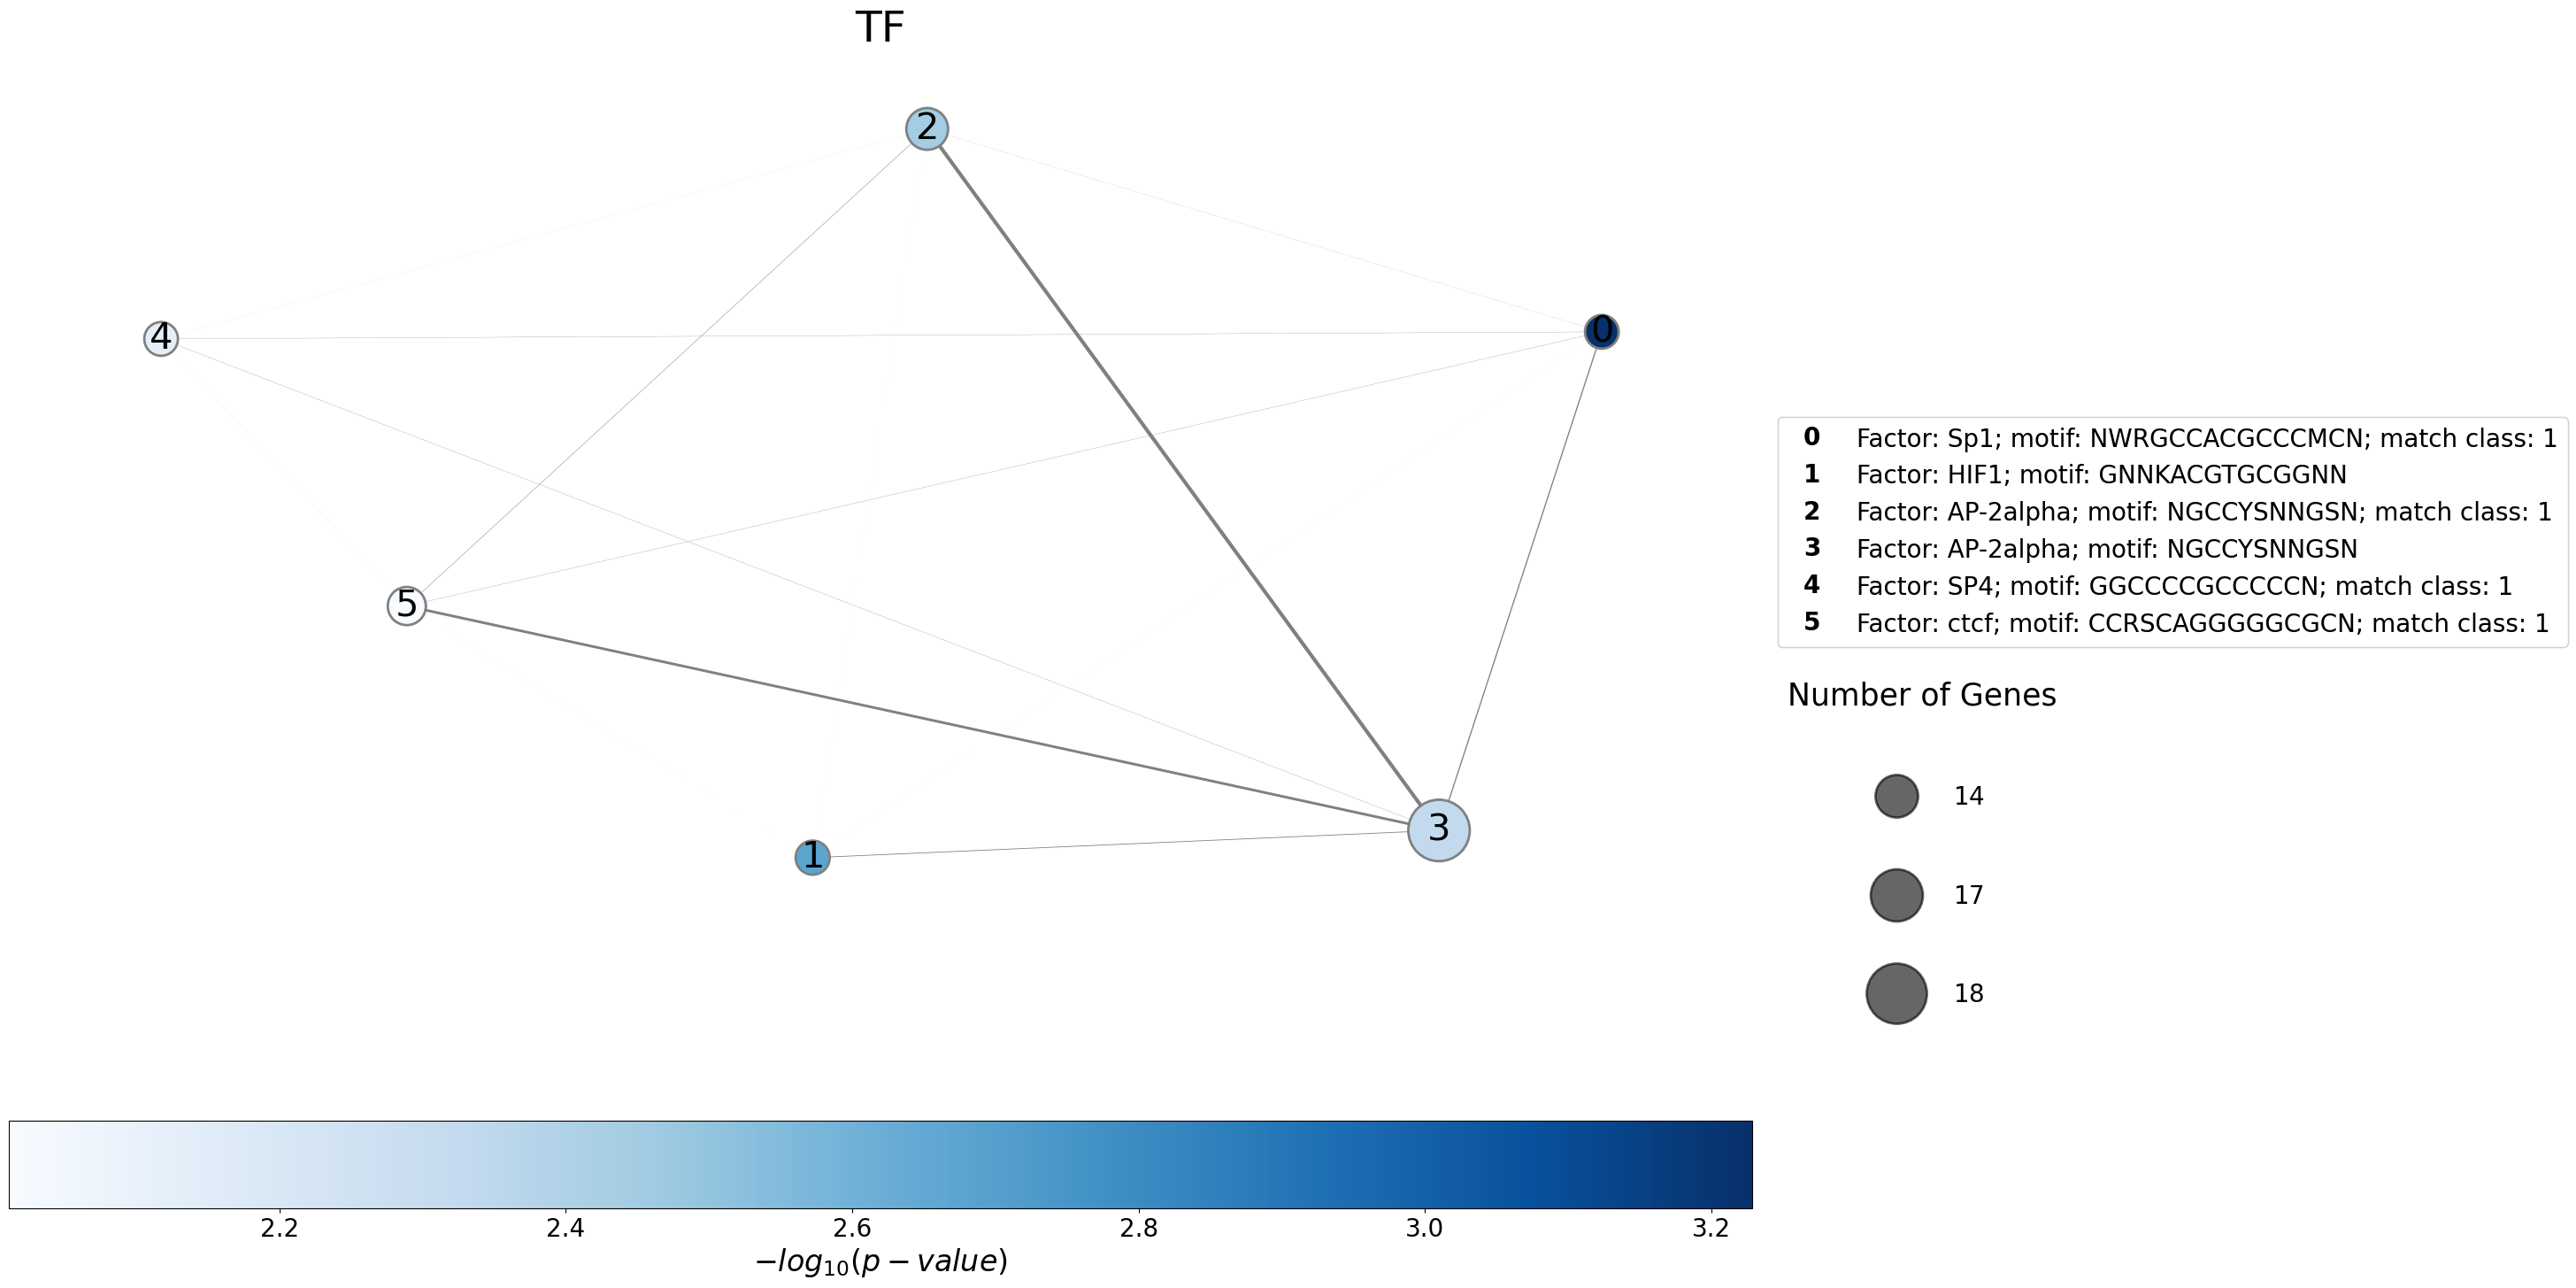

In [59]:
PlotEnrich(OT_genes_symbol,0.01)

![](./img/Hif.png)
![](./img/sp1.png)
![](./img/AP2a.png)

We can see that the functions enriched in the genes coming from OT L2G pipelines are related to TFs that are already reported in literature to be relevant for the development of IDD. 

![](../img/Hif.png)
![](../img/sp1.png)
![](../img/AP2a.png)

# Now we will use the function FuEnViz to visualize interactively the functions associated to IDD and the connections between the genes we obtained with OT L2G pipeline


In [ ]:
gp.function_enrichment_visualization(OT_genes_symbol)